In [75]:
import pickle
import numpy as np

In [76]:
with open('./data/train_qa','rb') as f:
    train_data = pickle.load(f)

In [77]:
with open('./data/test_qa','rb') as f:
    test_data = pickle.load(f)

In [78]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [79]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [80]:
train_data[0][2]

'no'

In [81]:
dataset = test_data + train_data

In [82]:
vocab =set()

for story,question,answer in dataset:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

vocab.add('no')
vocab.add('yes')

In [83]:
vocab_len = len(vocab) + 1 

In [84]:
max_story_len = max([len(data[0]) for data in dataset])
max_story_len

156

In [85]:
max_question_len = max([len(data[1]) for data in dataset])
max_question_len

6

In [86]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [87]:
vocab_size = len(vocab) + 1

In [88]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [89]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [90]:
tokenizer.word_index

{'got': 1,
 'milk': 2,
 'up': 3,
 'picked': 4,
 'grabbed': 5,
 'put': 6,
 'sandra': 7,
 'mary': 8,
 'john': 9,
 'to': 10,
 'travelled': 11,
 'took': 12,
 'went': 13,
 '?': 14,
 'in': 15,
 'moved': 16,
 'discarded': 17,
 'football': 18,
 'down': 19,
 'garden': 20,
 'the': 21,
 'there': 22,
 'dropped': 23,
 'yes': 24,
 'daniel': 25,
 'hallway': 26,
 'kitchen': 27,
 'journeyed': 28,
 'is': 29,
 'bathroom': 30,
 '.': 31,
 'left': 32,
 'no': 33,
 'back': 34,
 'apple': 35,
 'bedroom': 36,
 'office': 37}

In [91]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [92]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [93]:
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):
    # Stories
    X = []
    # Questions
    Xq = []
    # Y correct answer
    Y =[]
    
    for story,query,answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        y = np.zeros(len(word_index)+1)
        
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    
    return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len),np.array(Y))

In [94]:
inputs_train,queries_train,answers_train = vectorize_stories(train_data)

In [95]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [96]:
from keras.models import Sequential,Model
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [97]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [98]:
# Input Encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# Input Encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

# Question Encoder
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [99]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [100]:
match = dot([input_encoded_m,question_encoded],axes=(2,2))
match = Activation('softmax')(match)

In [101]:
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [102]:
answer = concatenate([response,question_encoded])
answer

<tf.Tensor 'concatenate_2/concat:0' shape=(?, 6, 220) dtype=float32>

In [103]:
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

In [104]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [105]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       multiple             2432        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 6, 64)        2432        input_4[0][0]                    
__________________________________________________________________________________________________
dot_2 (Dot

In [106]:
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 11s 1ms/step - loss: 0.8406 - acc: 0.4950 - val_loss: 0.6946 - val_acc: 0.4970
Epoch 2/120
10000/10000 [==============================] - 8s 832us/step - loss: 0.6982 - acc: 0.5034 - val_loss: 0.6934 - val_acc: 0.4970
Epoch 3/120
10000/10000 [==============================] - 8s 786us/step - loss: 0.6960 - acc: 0.5024 - val_loss: 0.6933 - val_acc: 0.4970
Epoch 4/120
10000/10000 [==============================] - 8s 784us/step - loss: 0.6955 - acc: 0.4908 - val_loss: 0.6948 - val_acc: 0.4970
Epoch 5/120
10000/10000 [==============================] - 8s 836us/step - loss: 0.6944 - acc: 0.5068 - val_loss: 0.6940 - val_acc: 0.4970
Epoch 6/120
10000/10000 [==============================] - 8s 791us/step - loss: 0.6950 - acc: 0.5049 - val_loss: 0.6941 - val_acc: 0.4970
Epoch 7/120
10000/10000 [==============================] - 8s 796us/step - loss: 0.6940 - acc: 0.5075 - val_loss: 0.69

In [116]:
model.save('./models/chatbot_120e.h5')

In [117]:
pickle.dump(tokenizer,open('./models/chatbot_token','wb'))

In [109]:
# from keras.models import load_model

# model = model = load_model('./models/chatbot_120e.h5')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


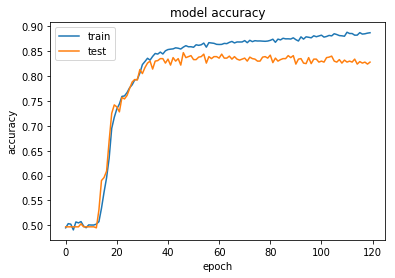

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
pred_results = model.predict(([inputs_test,queries_test]))

In [120]:
my_story = "John left the kitchen . Sandra dropped the football in the bedroom ."
my_question = "Is the football in the hallway ?"

In [121]:
def get_answer(story,question):
    my_data = [(story.split(),question.split(),'yes')]
    story, question, my_answer = vectorize_stories(my_data)
    pred_results = model.predict(([story, question]))
    print(pred_results)
    val_max = np.argmax(pred_results[0])
    print(val_max)
    for key,val in tokenizer.word_index.items():
        if val == val_max:
            k = key
    return k

In [114]:
get_answer(my_story,my_question)

[[1.28909464e-17 1.05900187e-17 1.31151943e-17 1.18204655e-17
  1.25079726e-17 1.28765949e-17 1.15838803e-17 1.44449988e-17
  9.92402992e-18 1.50549535e-17 1.54232639e-17 1.20636773e-17
  1.66676844e-17 1.03606158e-17 1.01945436e-17 1.52534653e-17
  1.31747662e-17 1.03575338e-17 1.35568326e-17 1.07381328e-17
  1.31001942e-17 9.84105543e-18 1.33105537e-17 9.92501426e-18
  1.86562873e-02 1.07748977e-17 1.50124579e-17 1.25846448e-17
  1.13133823e-17 1.29162954e-17 1.13363217e-17 1.17592558e-17
  1.28677068e-17 9.81343627e-01 1.22558967e-17 1.17428934e-17
  1.12081823e-17 1.32566372e-17]]
33


'no'